<a href="https://colab.research.google.com/github/RayBasilio123/R5/blob/master/INMET_DatasetR5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data treatment

In [19]:
#imports
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import timedelta
import itertools
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [20]:
#setting parameters for graphics
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16,9

In [40]:
#reading file
url = 'https://raw.githubusercontent.com/RayBasilio123/INMET_Dados_R3/master/a521%202018-2019.txt?token=AOAZ4LQMTS3RCAZRUPPPE427CDJIA'
read_table = pd.read_table(url, delim_whitespace=True, usecols=["ID",'ANO','MES','DIA','HORA',"RAD","VENTOVEL"])
df = pd.DataFrame(read_table)

In [22]:
#replacing negative radiation values
df = df.assign(RAD = df.RAD.where(df.RAD.ge(0)))

In [23]:
#grouping dates 
source_col_loc = df.columns.get_loc('ID') 

df['datetime'] = df.iloc[:,source_col_loc+1:source_col_loc+5].apply(
    lambda x: "-".join(x.astype(str)), axis=1)

In [24]:
#mounting the datetime 
dataFormatada = pd.to_datetime(df['datetime'], format='%Y-%m-%d-%H')

d = {'date':dataFormatada, 'ventovel': df['VENTOVEL'], 'radiacao': df['RAD'] }
f= {'date': dataFormatada}

dataFrame = pd.DataFrame(data=d).fillna(0) #datetime + ventovel + radiacao

frameList = list(dataFrame.date) #list of all dates in 'dataFrame'
dataFrame.head()

,date,ventovel,radiacao
0,2018-01-01 00:00:00,0.7,0.0
1,2018-01-01 01:00:00,0.8,0.0
2,2018-01-01 02:00:00,0.6,0.0
3,2018-01-01 03:00:00,0.3,0.0
4,2018-01-01 04:00:00,0.3,0.0


In [25]:
#creating all dates 
#date_list = [pd.to_datetime('2018-01-01 01:00:00') + timedelta(hours=x) for x in range(date.shape[date])] (RASCUNHO)

serieStart = '2018-01-01 00:00:00' 
serieEnd = '2019-12-31 23:00:00'

date = pd.date_range(start=serieStart, end=serieEnd, freq='1H')

dt = {'date': date}
frameDate = date #list of dates all dates in 'date'


In [26]:
#including the missing dates + nan values

new_dates = []
new_values_ventovel = []
new_values_rad = []

for i in frameDate:
  if i in frameList:
    new_dates.append(i)
    new_values_ventovel.append(float(dataFrame[dataFrame['date']==i]['ventovel']))
    new_values_rad.append(float(dataFrame[dataFrame['date']==i]['radiacao']))
  else:
    new_dates.append(i)
    new_values_ventovel.append(np.nan)
    new_values_rad.append(np.nan)

In [27]:
#transforming data in series end interpolate NaN values
index = pd.DatetimeIndex(new_dates)
series_ventovel = pd.Series(new_values_ventovel, index=index).interpolate()
series_radiacao = pd.Series(new_values_rad, index=index).interpolate()
series_ventovel.head()

2018-01-01 00:00:00    0.7
2018-01-01 01:00:00    0.8
2018-01-01 02:00:00    0.6
2018-01-01 03:00:00    0.3
2018-01-01 04:00:00    0.3
dtype: float64

In [28]:
#exporting to csv
series_ventovel.to_csv('/content/sample_data/series_ventovel')
series_radiacao.to_csv('/content/sample_data/series_radiacao')

#ANALYZING DATA

In [29]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import pandas as pd

serie_rad = pd.read_csv('/content/sample_data/series_radiacao', header=0, index_col=0)
serie_ven = pd.read_csv('/content/sample_data/series_ventovel', header=0, index_col=0)
serie_ven.head()

,0
2018-01-01 00:00:00,0.7
2018-01-01 01:00:00,0.8
2018-01-01 02:00:00,0.6
2018-01-01 03:00:00,0.3
2018-01-01 04:00:00,0.3


In [30]:
p, c = pacf(serie_ven,nlags=168, alpha=0.05)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


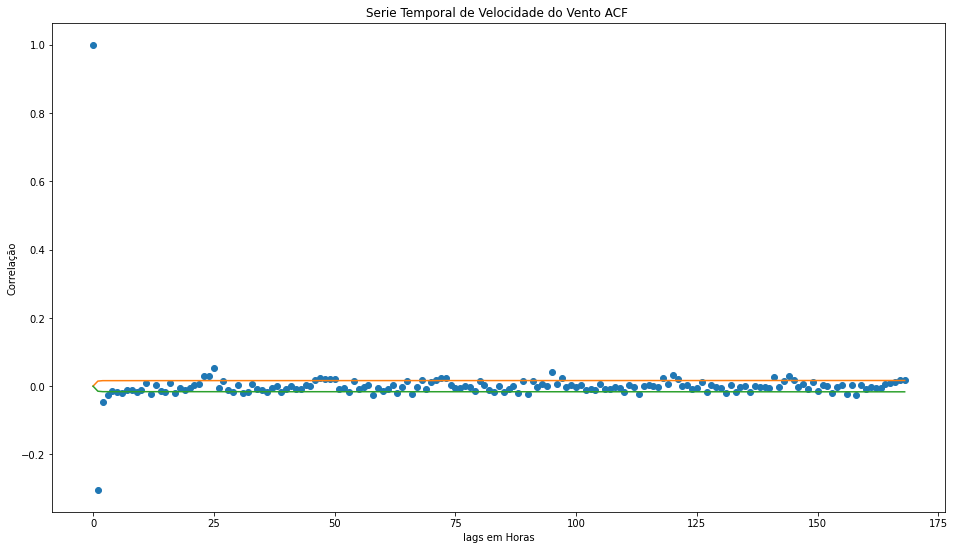

In [31]:

p2, c2 = acf((serie_ven.values[:-1] - serie_ven.values[1:]),nlags=168, alpha=0.05)
#fazer :
#ACF -> Sem Diff e com Diff para achar o Q 
#PACF-> Sem Diff e com Diff para achar o P
#d = 0 , q0 -> ACF e p0-> PACF
# d = 1 , q1 -> ACF e p1-> PACF
# ARIMA(p0,d0,q0)
# ARIMA(p1,d1,q1)

plt.plot(p2,'o')
plt.plot(c2[:,1]-p2)
plt.plot(c2[:,0]-p2)
plt.title('Serie Temporal de Velocidade do Vento ACF ')
plt.xlabel('lags em Horas')
plt.ylabel('Correlação')
plt.show()

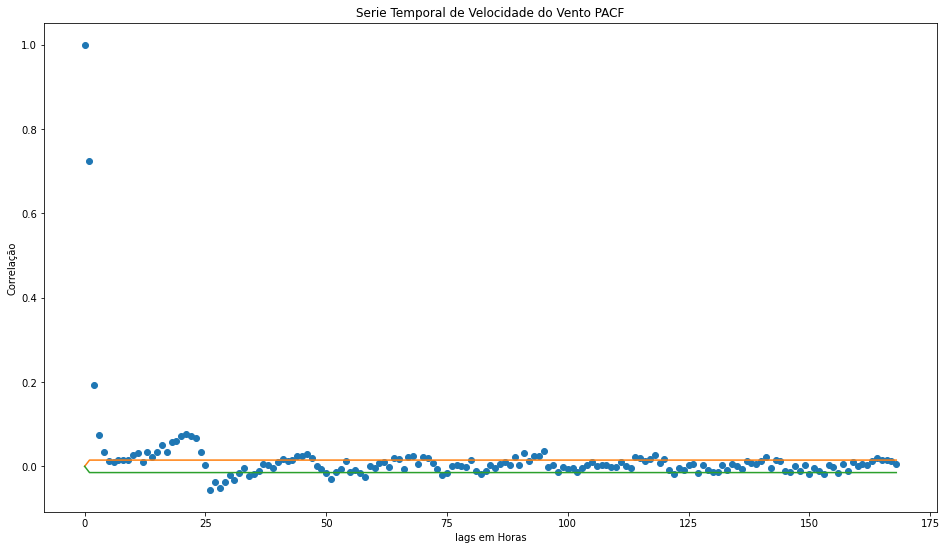

In [32]:
import matplotlib.pyplot as plt
plt.plot(p,'o')
plt.plot(c[:,1]-p)
plt.plot(c[:,0]-p)
plt.title('Serie Temporal de Velocidade do Vento PACF')
plt.xlabel('lags em Horas')
plt.ylabel('Correlação')
plt.show()

In [33]:
cont_Ordem = 0
for _p,_c0,_c1 in zip(p,c[:,0],c[:,1]):
  if _p > (_c1-_p) or _p < (_c0-_p):
    cont_Ordem+=1
  else:
    break
print(cont_Ordem)  

5


In [34]:
cont = 0
lista_Relevancia = []
for _p,_c0,_c1 in zip(p,c[:,0],c[:,1]):
  if _p > (_c1-_p) or _p < (_c0-_p):
    lista_Relevancia.append(1)
    
  else:
    lista_Relevancia.append(0)
 


In [35]:
lista_Relevancia

[1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0]

In [36]:
p1, c1 = pacf(serie_rad,nlags=168, alpha=0.05)

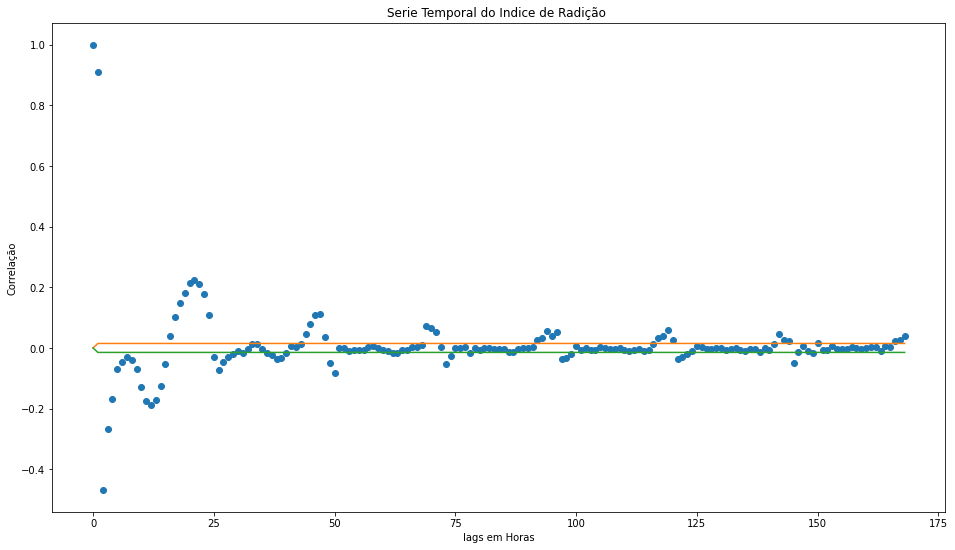

In [37]:
import matplotlib.pyplot as plt
plt.plot(p1,'o')
plt.plot(c1[:,1]-p1)
plt.plot(c1[:,0]-p1)
plt.title('Serie Temporal do Indice de Radição ')
plt.xlabel('lags em Horas')
plt.ylabel('Correlação')
plt.show()

In [38]:
cont_Ordem = 0
for _p,_c0,_c1 in zip(p1,c1[:,0],c1[:,1]):
  if _p > (_c1-_p) or _p < (_c0-_p):
    cont_Ordem+=1
  else:
    break
print(cont_Ordem)  

30


In [39]:
cont = 0
lista_Relevancia = []
for _p,_c0,_c1 in zip(p,c[:,0],c[:,1]):
  if _p > (_c1-_p) or _p < (_c0-_p):
    lista_Relevancia.append(1)
    
  else:
    lista_Relevancia.append(0)
 